# Импорт библиотек

In [1]:
import os
import shutil
from tqdm import tqdm
from random import shuffle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from glob import glob

from keras import backend as K
import random
import albumentations as A
from sklearn.model_selection import train_test_split, StratifiedKFold

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.models import *
from tensorflow.keras.preprocessing.image import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.applications.efficientnet import *

tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Создание датафреймов (путь/класс)

In [2]:
train_df = pd.DataFrame(columns=['id', 'path'])
train_df['path'] = glob('data/train/*/*')
train_df['id'] = train_df.path.apply(lambda x: x.split('/')[-1])
train_df['class'] = train_df.path.apply(lambda x: int(x.split('/')[-2]))
train_df.groupby('class').id.count()

class
0     69
1    299
3    210
Name: id, dtype: int64

In [3]:
test_df = pd.DataFrame(columns=['id', 'path'])
test_df['path'] = glob('data/test/*')
test_df['id'] = test_df.path.apply(lambda x: x.split('/')[-1])

Просмотр случайных изображений для каждого класса

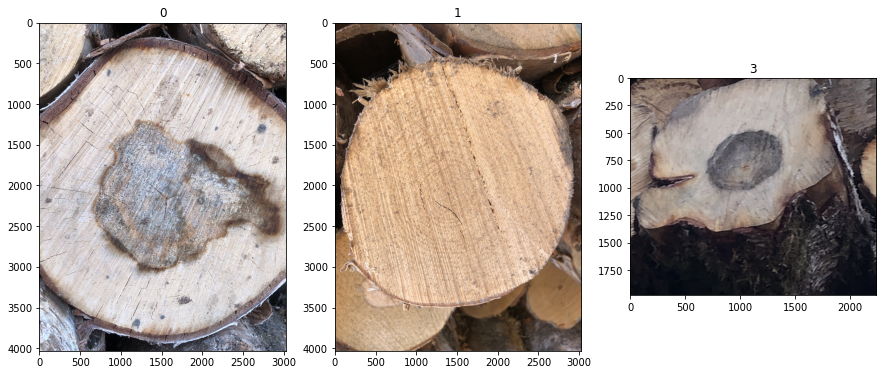

In [4]:
fig, ax = plt.subplots(1, 3, figsize=(15, 10))

ax[0].imshow(cv2.cvtColor(cv2.imread(train_df[train_df['class'] == 0].path.iloc[np.random.randint(0, 50)]), 
                          cv2.COLOR_BGR2RGB))
ax[0].set_title('0')
ax[1].imshow(cv2.cvtColor(cv2.imread(train_df[train_df['class'] == 1].path.iloc[np.random.randint(0, 50)]), 
                          cv2.COLOR_BGR2RGB))
ax[1].set_title('1')
ax[2].imshow(cv2.cvtColor(cv2.imread(train_df[train_df['class'] == 3].path.iloc[np.random.randint(0, 50)]), 
                          cv2.COLOR_BGR2RGB))
ax[2].set_title('3')

plt.show()

# Предобработка данных

Изначально данные хранятся в очень высоком разрешении, что сильно тормозит их загрузку. Поэтому перезаписываю данные, уменьшив их разрешение до фиксированного.

При этом, сразу решаю проблему того, что изображения не квадратные. Делаю фиксированный размер (512) для наибольшего измерения. Меньшее измерение изменяю пропорционально.

Сразу меняю пути до изображений в датасетах

In [5]:
for i in tqdm(range(train_df.shape[0])):
    
    image = cv2.imread(train_df.path.loc[i]).copy()
    xshape = image.shape[0]
    yshape = image.shape[1]
    if xshape <= yshape:
        image = cv2.resize(image.copy(), ( 512, int((512 / yshape) * xshape) ))
    else:
        image = cv2.resize(image.copy(), ( int((512 / xshape) * yshape), 512 ))
    
    cv2.imwrite('data_processed/train/{}'.format(train_df.id.iloc[i]), image)
    
train_df['path'] = train_df.id.apply(lambda x: 'data_processed/train/'+x)

100%|█████████████████████████████████████████| 578/578 [03:29<00:00,  2.76it/s]


In [6]:
for i in tqdm(range(test_df.shape[0])):
    
    image = cv2.imread(test_df.path.loc[i]).copy()
    xshape = image.shape[0]
    yshape = image.shape[1]
    if xshape <= yshape:
        image = cv2.resize(image.copy(), ( 512, int((512 / yshape) * xshape) ))
    else:
        image = cv2.resize(image.copy(), ( int((512 / xshape) * yshape), 512 ))
    
    cv2.imwrite('data_processed/test/{}'.format(test_df.id.iloc[i]), image)
    
test_df['path'] = test_df.id.apply(lambda x: 'data_processed/test/'+x)

100%|█████████████████████████████████████████| 249/249 [01:28<00:00,  2.80it/s]


# Аугментация и генератор данных

Создаю функцию для пэддинга изображений до квадратных. Данная функция из библиотеки albumentations работает как нельзя удобно, так как делает пэддинг не просто нулевымии значениями, а зеркальными(?) фрагментами.

In [7]:
def pad_image(image):
    aug = A.Compose([A.PadIfNeeded(512, 512, p=1.0)])
    augmented = aug(image=image)
    return augmented['image'] 

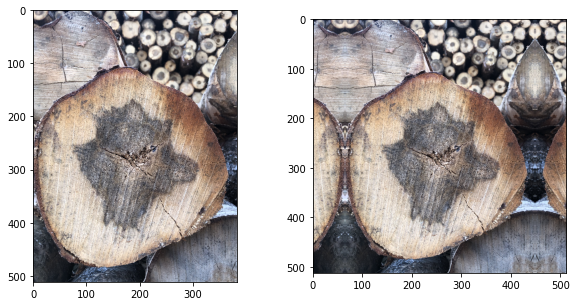

In [8]:
_, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(cv2.cvtColor(cv2.imread(train_df.path.iloc[0]), cv2.COLOR_BGR2RGB))
ax[1].imshow(pad_image(cv2.cvtColor(cv2.imread(train_df.path.iloc[0]), cv2.COLOR_BGR2RGB)))
plt.show()

Путем экспериментов и логики оставил наиболее адекватные аугментации.

In [9]:
def augment_image(image, input_shape):

    aug = A.Compose([
#         геометрические преобразования
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.Rotate(limit=[0, 90], p=0.5),
#         цветовые преобразования
        A.RandomBrightnessContrast(p=0.3),
        # A.ToGray(p=0.1),
        A.CLAHE(p=0.3),
        A.FancyPCA(p=0.3),
        # A.Blur(),
        # A.GaussNoise(),
        # A.InvertImg(),
        # A.RGBShift(p=1),  
    ])
    augmented = aug(image=image)
    return augmented['image'] 

Кастомный генератор данных для удобства

In [10]:
class CustomDataGen(tf.keras.utils.Sequence):
    
    def __init__(self, df,
                 augment=True,
                 batch_size=8,
                 input_shape=(512, 512, 3),
                 shuffle=True):
        
        self.paths = df['path'].values
        self.labels = df['class'].values
        self.augment = augment
        self.batch_size = batch_size
        self.input_shape = input_shape
        self.shuffle = shuffle
        self.n = len(self.paths)
        self.on_epoch_end()
        
    
    def on_epoch_end(self):
        
        self.indexes = np.arange(len(self.paths))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    
    def __load_data(self, paths, labels):
    
        X_batch = []
        y_batch = []
        
        for path, label in zip(paths, labels):
            
            X = cv2.cvtColor(cv2.imread(path).copy(), cv2.COLOR_BGR2RGB)
            
            X = pad_image(X)
            
            X = cv2.resize(X, (self.input_shape[0], self.input_shape[1]))
            if self.augment:
                X = augment_image(X, self.input_shape)

            X_batch.append(X / 255.)
            
            y = np.zeros(3)
            if label == 3:
                y[2] = 1
            else:
                y[label] = 1
            y_batch.append(y)
            
        return np.array(X_batch, dtype=np.float32), np.array(y_batch, dtype=np.float32)
    
    
    def __getitem__(self, index):
        
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        X, y = self.__load_data([self.paths[i] for i in indexes],
                                [self.labels[i] for i in indexes])        
        
        return X, y
    
    
    def __len__(self):
        
        return int(np.floor(len(self.paths) / self.batch_size))

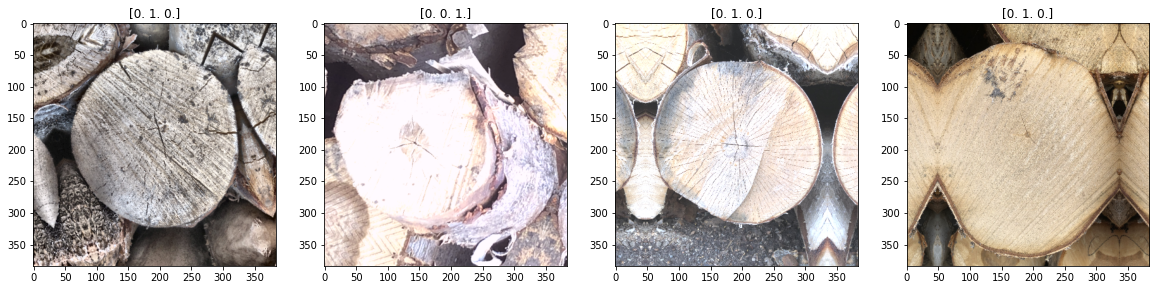

In [11]:
traingen = CustomDataGen(train_df, augment=True,
                         input_shape=(384, 384, 3), 
                         batch_size=4)

for x, y in traingen:
    break
    
_, ax = plt.subplots(1, 4, figsize=(20, 5))

for i, (xx, yy) in enumerate(zip(x, y)):
    ax[i].imshow(xx)
    ax[i].set_title(str(yy))

plt.show()

# Создание модели

Функция для создания модели. В качестве бэкбоуна беру EfficientNetB0, так как данные не сильно сложные и классов немного. К тому же модель легче и быстрее обучается.

In [691]:
def create_model(input_shape=(512, 512, 3)):
    
    inputs = Input(input_shape)
    base_model = EfficientNetB0(input_shape=input_shape, include_top=False)
    
    x = base_model(inputs)
    x = GlobalAveragePooling2D()(x)
    
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.05)(x)
    outputs = Dense(3, activation='softmax')(x)
    
    model = Model(inputs, outputs)
    
    return model

In [692]:
K.clear_session()

ISHAPE = 256

model = create_model((ISHAPE, ISHAPE, 3))

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

# Обучение модели
Одиночная модель для создания итоговых предсказаний не использовалась.

Датасет делится на тренировочную и валидационную часть.

In [662]:
train_, val_ = train_test_split(train_df, test_size=0.15, stratify=train_df['class'])

Создаются генераторы данных.

In [672]:
traingen = CustomDataGen(train_, 
                         input_shape=(ISHAPE, ISHAPE, 3), 
                         batch_size=4)

valgen = CustomDataGen(val_, 
                       input_shape=(ISHAPE, ISHAPE, 3), 
                       batch_size=4, augment=False)

Прописываю коллбэки. Закомменченный код нужен для создания директории.

In [674]:
checkpoint_path = 'models/EfficientNetB0_rgb_padded_{}.h5'.format(ISHAPE)
# checkpoint_dir = os.path.dirname(checkpoint_path)
# if os.path.exists(checkpoint_dir):
#         shutil.rmtree(checkpoint_dir)
# os.makedirs(checkpoint_dir)

callbacks = [
    EarlyStopping(monitor='val_loss', mode='min', patience=20, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', mode='min', factor=0.35, patience=5, min_lr=1e-7, verbose=1),
    ModelCheckpoint(monitor='val_loss', mode='min', filepath=checkpoint_path, 
                    verbose=1, save_best_only=True, save_weights_only=False)
]

Обучаю модель.

In [695]:
history = model.fit(traingen, validation_data=valgen,
                    epochs=100,
                    callbacks=callbacks)

# Создание ансамбля моделей с помощью StratifiedKFold

In [ ]:
model_number = 0
ISHAPE = 256

for train_index, val_index in StratifiedKFold(n_splits=6, shuffle=True,
                                              random_state=17).split(train_df, train_df['class']):
    
    K.clear_session()
    
    model = create_model((ISHAPE, ISHAPE, 3))
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
                  loss=tf.keras.losses.CategoricalCrossentropy(),
                  metrics=['accuracy'])
    
    train_, val_ = train_df.iloc[train_index], train_df.iloc[val_index]
    
    traingen = CustomDataGen(train_, 
                             input_shape=(ISHAPE, ISHAPE, 3), 
                             batch_size=4)
    
    valgen = CustomDataGen(val_, 
                           input_shape=(ISHAPE, ISHAPE, 3), 
                           batch_size=4, augment=False)
    
    checkpoint_path = 'models/SKF_EfficientNetB0_{}_padded_{}.h5'.format(ISHAPE, model_number)
    model_number += 1
    
    callbacks = [
        EarlyStopping(monitor='val_loss', mode='min', patience=18, verbose=1),
        ReduceLROnPlateau(monitor='val_loss', mode='min', factor=0.35, patience=5, min_lr=1e-7, verbose=1),
        ModelCheckpoint(monitor='val_loss', mode='min', filepath=checkpoint_path, 
                        verbose=1, save_best_only=True, save_weights_only=False)
    ]
    
    history = model.fit(traingen, validation_data=valgen,
                        epochs=100,
                        callbacks=callbacks)

In [616]:
model_number = 0
ISHAPE = 384

for train_index, val_index in StratifiedKFold(n_splits=5, shuffle=True,
                                              random_state=17).split(train_df, train_df['class']):
    
    K.clear_session()
    
    model = create_model((ISHAPE, ISHAPE, 3))
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
                  loss=tf.keras.losses.CategoricalCrossentropy(),
                  metrics=['accuracy'])
    
    train_, val_ = train_df.iloc[train_index], train_df.iloc[val_index]
    
    traingen = CustomDataGen(train_, 
                             input_shape=(ISHAPE, ISHAPE, 3), 
                             batch_size=4)
    
    valgen = CustomDataGen(val_, 
                           input_shape=(ISHAPE, ISHAPE, 3), 
                           batch_size=4, augment=False)
    
    checkpoint_path = 'models/SKF_EfficientNetB0_{}_padded_{}.h5'.format(ISHAPE, model_number)
    model_number += 1
    
    callbacks = [
        EarlyStopping(monitor='val_loss', mode='min', patience=18, verbose=1),
        ReduceLROnPlateau(monitor='val_loss', mode='min', factor=0.35, patience=5, min_lr=1e-7, verbose=1),
        ModelCheckpoint(monitor='val_loss', mode='min', filepath=checkpoint_path, 
                        verbose=1, save_best_only=True, save_weights_only=False)
    ]
    
    history = model.fit(traingen, validation_data=valgen,
                        epochs=100,
                        callbacks=callbacks)

Epoch 1/100


2022-04-17 03:12:52.697738: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


115/115 [==============================] - ETA: 0s - loss: 0.7225 - accuracy: 0.7413

2022-04-17 03:14:55.236120: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 1.07056, saving model to models/SKF_EfficientNetB0_384_padded_0.h5
115/115 [==============================] - 145s 977ms/step - loss: 0.7225 - accuracy: 0.7413 - val_loss: 1.0706 - val_accuracy: 0.5172 - lr: 5.0000e-05
Epoch 2/100
115/115 [==============================] - ETA: 0s - loss: 0.4680 - accuracy: 0.8130
Epoch 2: val_loss improved from 1.07056 to 1.03162, saving model to models/SKF_EfficientNetB0_384_padded_0.h5
115/115 [==============================] - 80s 692ms/step - loss: 0.4680 - accuracy: 0.8130 - val_loss: 1.0316 - val_accuracy: 0.5172 - lr: 5.0000e-05
Epoch 3/100
115/115 [==============================] - ETA: 0s - loss: 0.3774 - accuracy: 0.8587
Epoch 3: val_loss did not improve from 1.03162
115/115 [==============================] - 75s 651ms/step - loss: 0.3774 - accuracy: 0.8587 - val_loss: 1.0872 - val_accuracy: 0.4483 - lr: 5.0000e-05
Epoch 4/100
115/115 [==============================] - ETA: 0s - loss: 0.3315 - accuracy

2022-04-17 04:26:23.452176: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


115/115 [==============================] - ETA: 0s - loss: 0.7430 - accuracy: 0.7239

2022-04-17 04:28:19.079602: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 1.06696, saving model to models/SKF_EfficientNetB0_384_padded_1.h5
115/115 [==============================] - 135s 933ms/step - loss: 0.7430 - accuracy: 0.7239 - val_loss: 1.0670 - val_accuracy: 0.5172 - lr: 5.0000e-05
Epoch 2/100
115/115 [==============================] - ETA: 0s - loss: 0.4328 - accuracy: 0.8478
Epoch 2: val_loss improved from 1.06696 to 1.02704, saving model to models/SKF_EfficientNetB0_384_padded_1.h5
115/115 [==============================] - 75s 649ms/step - loss: 0.4328 - accuracy: 0.8478 - val_loss: 1.0270 - val_accuracy: 0.5172 - lr: 5.0000e-05
Epoch 3/100
115/115 [==============================] - ETA: 0s - loss: 0.4204 - accuracy: 0.8435
Epoch 3: val_loss did not improve from 1.02704
115/115 [==============================] - 73s 636ms/step - loss: 0.4204 - accuracy: 0.8435 - val_loss: 1.1307 - val_accuracy: 0.1983 - lr: 5.0000e-05
Epoch 4/100
115/115 [==============================] - ETA: 0s - loss: 0.3096 - accuracy

2022-04-17 05:22:30.930117: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


115/115 [==============================] - ETA: 0s - loss: 0.6991 - accuracy: 0.7413

2022-04-17 05:24:22.537435: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 1.08068, saving model to models/SKF_EfficientNetB0_384_padded_2.h5
115/115 [==============================] - 131s 895ms/step - loss: 0.6991 - accuracy: 0.7413 - val_loss: 1.0807 - val_accuracy: 0.5172 - lr: 5.0000e-05
Epoch 2/100
115/115 [==============================] - ETA: 0s - loss: 0.4956 - accuracy: 0.8043
Epoch 2: val_loss improved from 1.08068 to 1.07169, saving model to models/SKF_EfficientNetB0_384_padded_2.h5
115/115 [==============================] - 74s 647ms/step - loss: 0.4956 - accuracy: 0.8043 - val_loss: 1.0717 - val_accuracy: 0.5172 - lr: 5.0000e-05
Epoch 3/100
115/115 [==============================] - ETA: 0s - loss: 0.3246 - accuracy: 0.8696
Epoch 3: val_loss did not improve from 1.07169
115/115 [==============================] - 74s 642ms/step - loss: 0.3246 - accuracy: 0.8696 - val_loss: 1.1029 - val_accuracy: 0.2672 - lr: 5.0000e-05
Epoch 4/100
115/115 [==============================] - ETA: 0s - loss: 0.3386 - accuracy

2022-04-17 06:21:04.297656: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


115/115 [==============================] - ETA: 0s - loss: 0.7518 - accuracy: 0.7043

2022-04-17 06:22:53.967762: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 1.07008, saving model to models/SKF_EfficientNetB0_384_padded_3.h5
115/115 [==============================] - 129s 913ms/step - loss: 0.7518 - accuracy: 0.7043 - val_loss: 1.0701 - val_accuracy: 0.5268 - lr: 5.0000e-05
Epoch 2/100
115/115 [==============================] - ETA: 0s - loss: 0.4766 - accuracy: 0.8022
Epoch 2: val_loss did not improve from 1.07008
115/115 [==============================] - 74s 644ms/step - loss: 0.4766 - accuracy: 0.8022 - val_loss: 1.0756 - val_accuracy: 0.5179 - lr: 5.0000e-05
Epoch 3/100
115/115 [==============================] - ETA: 0s - loss: 0.4199 - accuracy: 0.8522
Epoch 3: val_loss did not improve from 1.07008
115/115 [==============================] - 73s 638ms/step - loss: 0.4199 - accuracy: 0.8522 - val_loss: 1.0788 - val_accuracy: 0.4286 - lr: 5.0000e-05
Epoch 4/100
115/115 [==============================] - ETA: 0s - loss: 0.2886 - accuracy: 0.9022
Epoch 4: val_loss did not improve from 1.07008
115/115

2022-04-17 07:25:53.617328: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


115/115 [==============================] - ETA: 0s - loss: 0.7896 - accuracy: 0.6848

2022-04-17 07:27:46.631086: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 1.07066, saving model to models/SKF_EfficientNetB0_384_padded_4.h5
115/115 [==============================] - 133s 908ms/step - loss: 0.7896 - accuracy: 0.6848 - val_loss: 1.0707 - val_accuracy: 0.5089 - lr: 5.0000e-05
Epoch 2/100
115/115 [==============================] - ETA: 0s - loss: 0.4570 - accuracy: 0.8283
Epoch 2: val_loss improved from 1.07066 to 1.04209, saving model to models/SKF_EfficientNetB0_384_padded_4.h5
115/115 [==============================] - 74s 644ms/step - loss: 0.4570 - accuracy: 0.8283 - val_loss: 1.0421 - val_accuracy: 0.5179 - lr: 5.0000e-05
Epoch 3/100
115/115 [==============================] - ETA: 0s - loss: 0.4070 - accuracy: 0.8478
Epoch 3: val_loss did not improve from 1.04209
115/115 [==============================] - 73s 636ms/step - loss: 0.4070 - accuracy: 0.8478 - val_loss: 1.1181 - val_accuracy: 0.1696 - lr: 5.0000e-05
Epoch 4/100
115/115 [==============================] - ETA: 0s - loss: 0.3283 - accuracy

# Создание предсказаний на тестовых данных

Отдельный генератор для тестовых данных. Объективно, можно было создать его вместе с генератором для обучения, прописав несколько условий, но я не стал запариваться над этим.

In [12]:
class TestCustomDataGen(tf.keras.utils.Sequence):
    
    def __init__(self, df,
                 augment=True,
                 batch_size=8,
                 input_shape=(512, 512, 3),
                 shuffle=True):
        
        self.paths = df['path'].values
        self.augment = augment
        self.batch_size = batch_size
        self.input_shape = input_shape
        self.n = len(self.paths)
        self.on_epoch_end()
        
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.paths))

    
    def __load_data(self, paths):
        X_batch = []
        for path in paths:
            X = cv2.cvtColor(cv2.imread(path).copy(), cv2.COLOR_BGR2RGB)
            X = pad_image(X)
            X = cv2.resize(X, (self.input_shape[0], self.input_shape[1]))
            if self.augment:
                X = augment_image(X, self.input_shape)
            X_batch.append(X / 255.)
        return np.array(X_batch, dtype=np.float32)
    
    
    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        X = self.__load_data([self.paths[i] for i in indexes])
        return X
    
    
    def __len__(self):
        return int(np.floor(len(self.paths) / self.batch_size))

Подгружаем модели

In [13]:
# 384
model_paths = [x for x in glob('models/SKF*384*padded*')]
print(model_paths)

models_384 = []
for path in model_paths:
    model = load_model(path)
    models_384.append(model)
    
# 256
model_paths = [x for x in glob('models/SKF*256*padded*')]
print(model_paths)

models_256 = []
for path in model_paths:
    model = load_model(path)
    models_256.append(model)

['models/SKF_EfficientNetB0_384_padded_1.h5', 'models/SKF_EfficientNetB0_384_padded_0.h5', 'models/SKF_EfficientNetB0_384_padded_4.h5', 'models/SKF_EfficientNetB0_384_padded_3.h5', 'models/SKF_EfficientNetB0_384_padded_2.h5']
Metal device set to: Apple M1


2022-04-17 17:21:59.787209: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-04-17 17:21:59.787343: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


['models/SKF_EfficientNetB0_256_padded_1.h5', 'models/SKF_EfficientNetB0_256_padded_5.h5', 'models/SKF_EfficientNetB0_256_padded_4.h5', 'models/SKF_EfficientNetB0_256_padded_0.h5', 'models/SKF_EfficientNetB0_256_padded_3.h5', 'models/SKF_EfficientNetB0_256_padded_2.h5']


Сборка предсказаний. Для каждой модели делаю 10 итераций предсказаний, так как включены аугментации, и на каждой итерации данные претерпевают некоторые изменения. Обычно данный способ называют - test time augmentation (TTA).

In [14]:
preds = np.zeros((249, 3))


testgen = TestCustomDataGen(test_df, input_shape=(384, 384, 3), 
                            augment=True, batch_size=1)
for model in models_384:
    for i in tqdm(range(10)):
        preds += model.predict(testgen)
        
        
testgen = TestCustomDataGen(test_df, input_shape=(256, 256, 3), 
                            augment=True, batch_size=1)
for model in models_256:
    for i in tqdm(range(10)):
        preds += model.predict(testgen)

# нормирование
preds /= (len(models_384) + len(models_256)) * 10

  0%|                                                    | 0/10 [00:00<?, ?it/s]2022-04-17 17:22:25.975081: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-04-17 17:22:26.591782: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
100%|███████████████████████████████████████████| 10/10 [01:01<00:00,  6.15s/it]


Преобразование предсказаний из вероятностей в классы.

In [15]:
preds_ = []
for pred in preds:
    preds_.append(np.where(pred == pred.max())[0][0])

Датасет с результатами

In [16]:
result = pd.DataFrame(columns=['id', 'class'])
result['id'] = test_df['id'].copy().apply(lambda x: int(x.split('.')[0]))
result['class'] = preds_
# заменяю 2 на 3 по тз
result.loc[result['class'] == 2, 'class'] = 3
result = result.sort_values('id')

In [17]:
result

,id,class
233,1,0
209,2,3
215,3,0
154,4,3
168,5,1
...,...,...
131,245,1
143,246,1
142,247,1
83,248,1


In [18]:
result.to_csv('rgb_skf_256_384_padded.csv', index=False)